In [1]:
from xdesign import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
import os

`polytope` failed to import `cvxopt.glpk`.
Will use `scipy.optimize.linprog`.


# Coverage maps figure with beam gap

Generating beam coverage for a raster scan procedures of different parameters. Only look at the middle `0.5**2` cm because those are the most interesting. Fix the probe width and change the pixel size and space between adjacent measurements.

In [2]:
ROI = [[0.25, 0.75], [0.25, 0.75]] # The region of interest for the coverage map
probe_width = 1/256 # The width of the probe in cm

num_angles = [101] # the number of projection angles
pixel_fractions = [1.] # the pixel size compared to the beam width
gap_fractions = [1./2, 1./4, 1./8, 1./16] # the fraction of space covered by the beam

## Helper Functions

In [3]:
def grid_plot(folder, num_angles, rows, cols):
    """Plot coverage maps from `folder` in a grid."""
    
    fig = plt.figure(figsize=(8.85/2.54, 8.85/2.54), dpi=400)

    for i in range(len(rows)):
        for j in range(len(cols)):

            # scale the results as fraction of the most covered pixel
            themap = np.load('./data/gap/{}/{}_{}_{}.npy'.format(folder, num_angles, cols[j], rows[i]))
            themap /= np.max(themap)
#             print(np.max(themap), np.min(themap))

            axis = plt.subplot(len(rows), len(cols), i*len(cols) + j + 1)
            plt.imshow(themap)
            plt.gca().get_yaxis().set_ticks([])
            plt.gca().get_xaxis().set_ticks([])


            text = axis.annotate("{:.3f}".format(np.std(themap)),
                                 xy=(0.05,0.05),
                                 xycoords='axes fraction',
                                 color='white',
                                 fontsize=8)

            text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                                   path_effects.Normal()])

            plt.clim([0, 1])
            if j == 0:
                plt.ylabel(str(rows[i]), fontsize=8)
            if i == len(rows) - 1:
                plt.xlabel(str(cols[j]), fontsize=8)
            plt.suptitle('{}\nfor {} projection angles'.format(folder, num_angles))
    
    plt.subplots_adjust(wspace=0, hspace=0, left=0.1, right=0.9, bottom=0.1, top=0.9)
    
    return fig

In [4]:
def generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions, folder, nmeta=1, random=False,
                  anisotropy=False):
    """Generate coverage maps for the given angles, pixel fractions, and gap fractions.
    Save the results to numpy files."""
    
    for ang in num_angles:
        for pix in pixel_fractions:
            for gap in gap_fractions:
                
                if anisotropy:
                    file = './data/gap/{}/a{}_{}_{}.npy'.format(folder, ang, pix, gap)
                else:
                    file = './data/gap/{}/{}_{}_{}.npy'.format(folder, ang, pix, gap)

                if not os.path.isfile(file):
                    num_steps = int(gap / probe_width)
                    pixel_size = pix * gap / num_steps
                    n_Riemann = int(np.ceil(16 * probe_width / pixel_size)) 
    #                 print(n_Riemann)

                    procedure = raster_scan(ang, num_steps, width_fraction=gap,
                                            nmeta=nmeta, random=random, plot=True)

                    cmap = coverage_approx(procedure, ROI, pixel_size, n=n_Riemann, anisotropy=anisotropy)

                    np.save(file, cmap)

## Calculate coverage as a function fo beam gap

In [17]:
# default raster scan
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions, 'raster coverage')

16
16
16
16


In [18]:
# meta-raster scan
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'meta-raster coverage', nmeta=0)

16
16
16
16


In [19]:
# random meta-raster scan
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'random meta-raster coverage', nmeta=0, random=True)

16
16
16
16


# Plot coverage parameterization

Make plots showing how the coverage changes for increasing sparsity of measurement and increasing pixel size.

In [49]:
def grid_plot2(num_angles):
    """Plot coverage maps from `folder` in a grid."""
    rows = ['raster', 'meta', 'random']
    cols = gap_fractions
    
    fig = plt.figure(figsize=(8.85/2.54, 8.85/2.54), dpi=400)

    for i, folder in enumerate(rows):
        for j in range(len(cols)):

            # scale the results as fraction of the most covered pixel
            themap = np.load('./data/gap/{}/{}_{}_{}.npy'.format(folder, num_angles, 1.0, cols[j]))
#             themap /= np.max(themap)
            themap /= 63.3144145097
            print(np.max(themap), np.min(themap))

            axis = plt.subplot(len(rows), len(cols), i*len(cols) + j + 1)
            plt.imshow(themap)
            plt.gca().get_yaxis().set_ticks([])
            plt.gca().get_xaxis().set_ticks([])


            text = axis.annotate("{:.3f}".format(np.std(themap)),
                                 xy=(0.05,0.05),
                                 xycoords='axes fraction',
                                 color='white',
                                 fontsize=8)

            text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                                   path_effects.Normal()])

            plt.clim([0, 1])
            if j == 0:
                plt.ylabel(str(rows[i]), fontsize=8)
            if i == len(rows) - 1:
                plt.xlabel(str(cols[j]), fontsize=8)
            plt.suptitle('sparsity comparison\nfor {} projection angles'.format(num_angles))
    
    plt.subplots_adjust(wspace=0, hspace=0, left=0.1, right=0.9, bottom=0.1, top=0.9)
    
    return fig

0.973646720963 0.61028492328
0.740679692092 0.0
0.550901115198 0.0
0.390193244657 0.0
0.988479651761 0.606468381198
0.645604467463 0.228177730594
0.466649695156 0.0816110876726
0.384234404254 0.0147664466909
1.0 0.595259893454
0.609269873622 0.217536188949
0.362683032694 0.0680517687374
0.247312218026 0.00110295662956


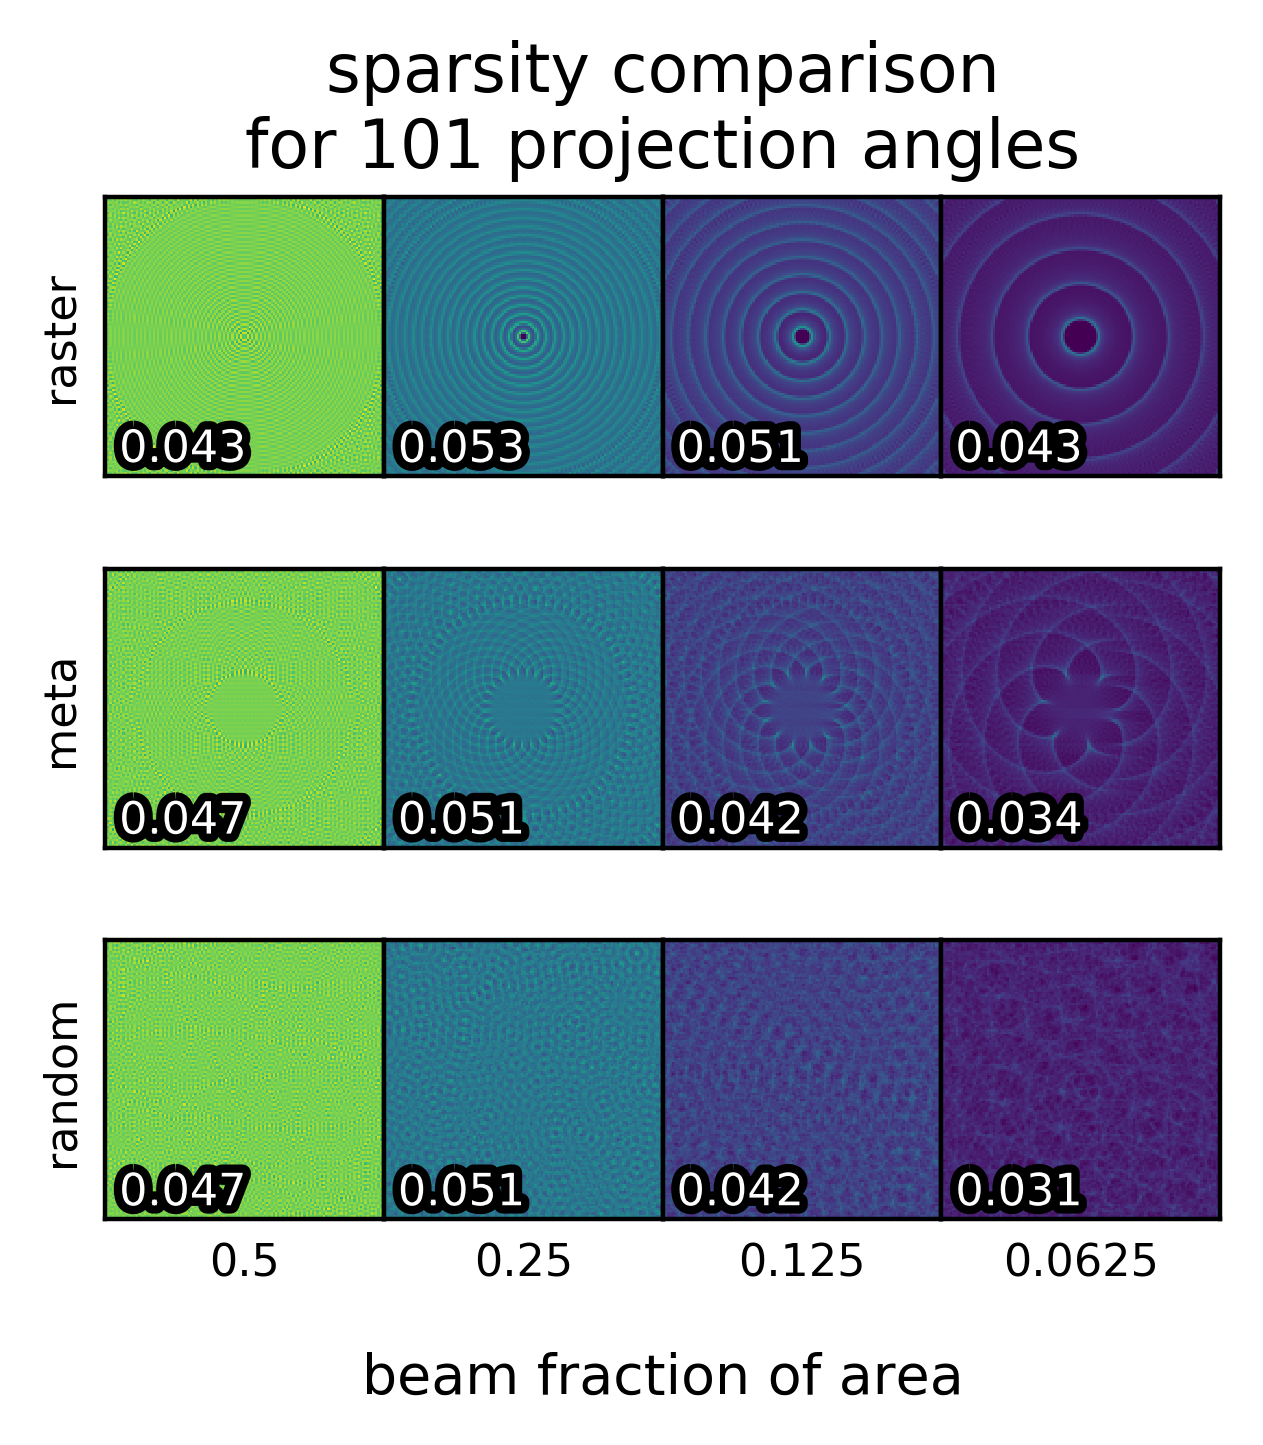

In [64]:
angles = 101
fig = grid_plot2(angles)

fig.text(0.5, 0.0, 'beam fraction of area', ha='center', va='bottom')

plt.savefig('./figures/gap/gap_compare_{}angles.png'.format(angles), format='png',
        transparent=False, bbox_inches=None, pad_inches=0,
        frameon=False)

plt.show()

In [37]:
# fig = grid_plot('meta-raster coverage', angles, gap_fractions, pixel_fractions)

# fig.text(0.5, 0.0, 'pixel to beam size ratio', ha='center', va='bottom')
# fig.text(0.0, 0.5, 'beam fraction of area', ha='left', va='center', rotation='vertical')

# plt.savefig('./figures/meta_coverage_{}angles.png'.format(angles), format='png',
#         transparent=True, bbox_inches=None, pad_inches=0,
#         frameon=False)

# plt.show()

In [36]:
# fig = grid_plot('random meta-raster coverage', angles, gap_fractions, pixel_fractions)

# fig.text(0.5, 0.0, 'pixel to beam size ratio', ha='center', va='bottom')
# fig.text(0.0, 0.5, 'beam fraction of area', ha='left', va='center', rotation='vertical')

# plt.savefig('./figures/rmeta_coverage_{}angles.png'.format(angles), format='png',
#         transparent=True, bbox_inches=None, pad_inches=0,
#         frameon=False)

# plt.show()

# Show the angle convergence of each scanning paradigm

See what happens as the number of projection angles goes to infinity for the three paradigms.

In [73]:
num_angles = [11,101,499,1009] #list({int(10**x) for x in np.arange(0, 3.1, 0.1)}) # the number of projection angles
pixel_fractions = [1.] # the pixel size compared to the beam width
gap_fractions = [1./8] # the fraction of space covered by the beam

In [74]:
# default scan
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'raster')
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'meta', nmeta=0)
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'random', nmeta=0, random=True)

1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.174887262372
1.0 0.381947705331
1.0 0.94417927867
1.0 0.0
1.0 0.187634277325
1.0 0.502538125841
1.0 0.59104878373


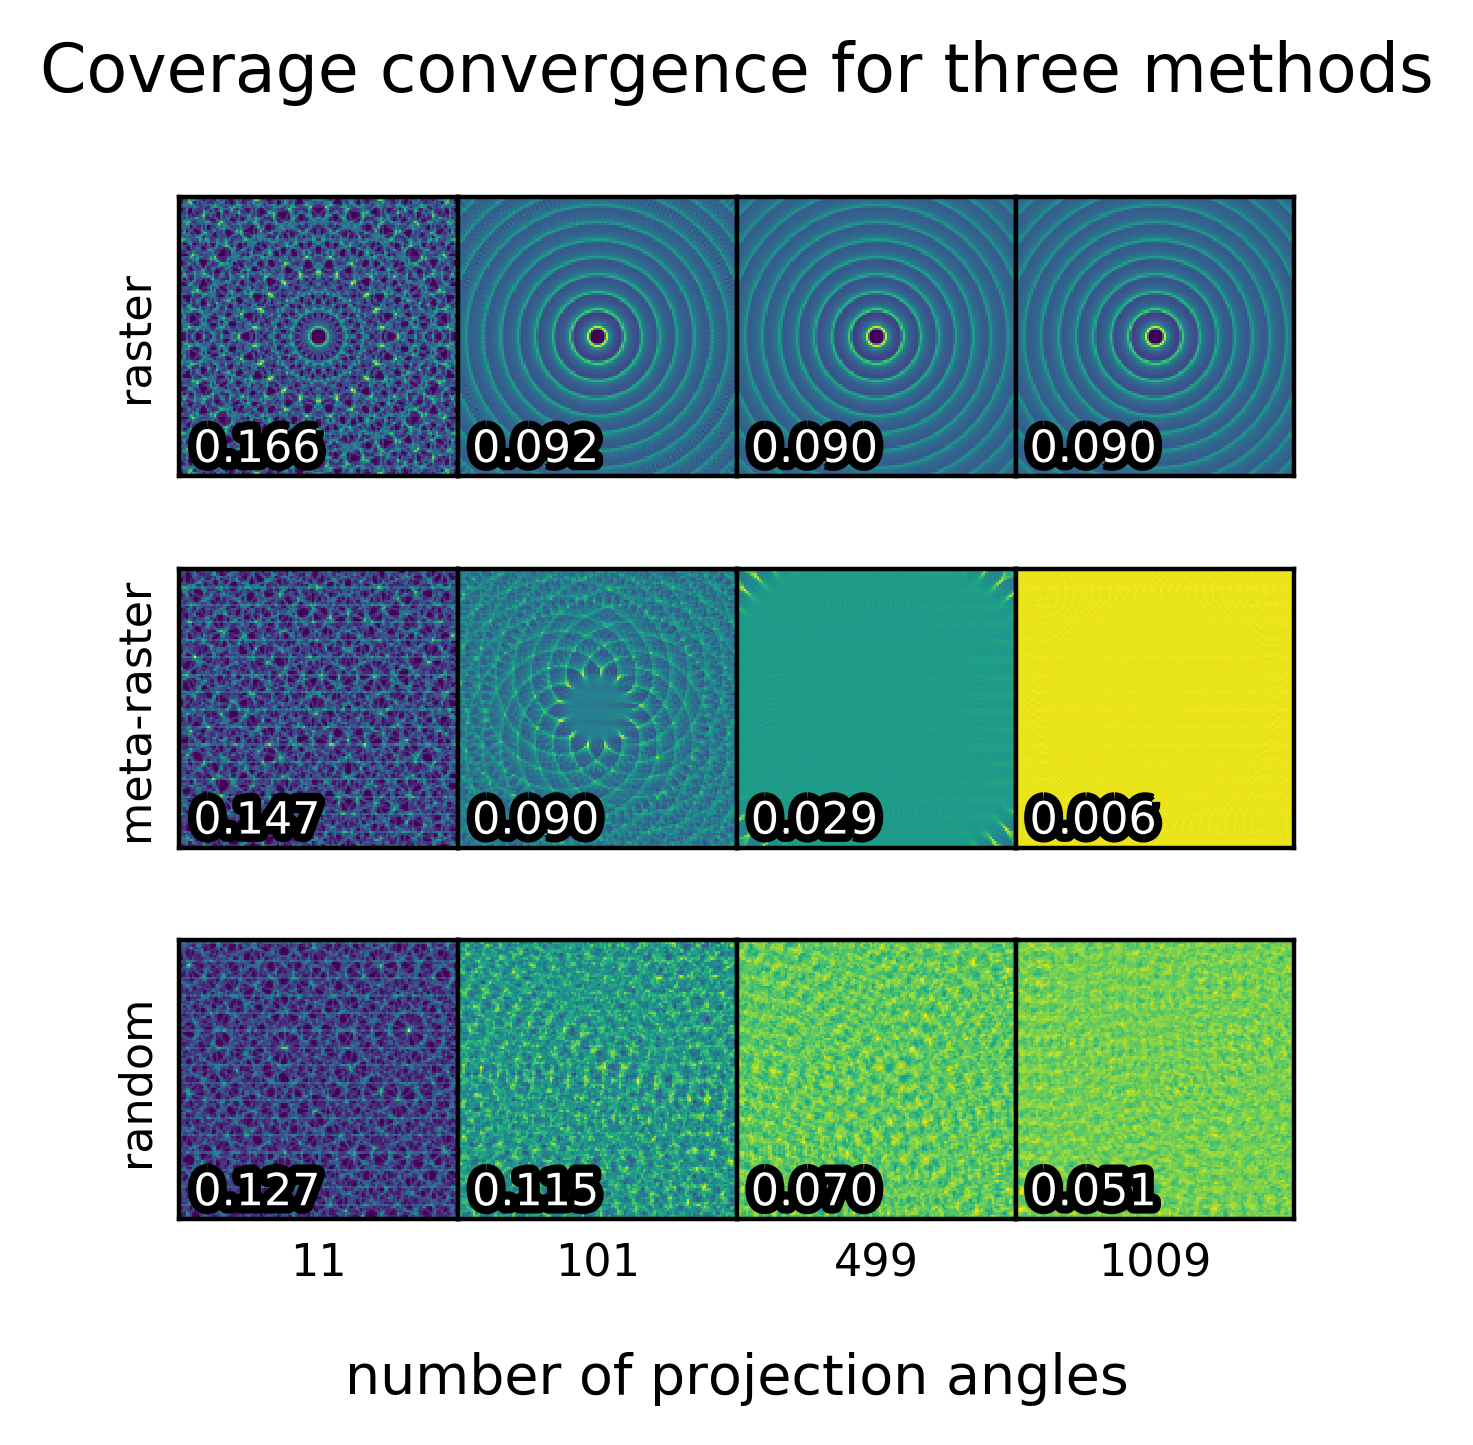

In [79]:
# def grid_plot(folder, num_angles, rows, cols):

num_angles = [11,101,499,1009]

fig = plt.figure(figsize=(8.85/2.54, 8.85/2.54), dpi=400)
folders = ['raster','meta','random']
short_names = ['raster', 'meta-raster', 'random']
cols = sorted(num_angles)
rows = folders

for i in range(len(rows)):
    for j in range(len(cols)):

        # scale the results as fraction of the most covered pixel
        themap = np.load('./data/gap/{}/{}_{}_{}.npy'.format(rows[i], cols[j], 1.0, 1./8))
        themap /= np.max(themap)
        print(np.max(themap), np.min(themap))

        axis = plt.subplot(len(rows), len(cols), i*len(cols) + j + 1)
        plt.imshow(themap)
        plt.gca().get_yaxis().set_ticks([])
        plt.gca().get_xaxis().set_ticks([])


        text = axis.annotate("{:.3f}".format(np.std(themap)),
                             xy=(0.05,0.05),
                             xycoords='axes fraction',
                             color='white',
                             fontsize=8)

        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                               path_effects.Normal()])

        plt.clim([0, 1])
        if j == 0:
            plt.ylabel(str(short_names[i]), fontsize=8)
        if i == len(rows) - 1:
            plt.xlabel(str(cols[j]), fontsize=8)
        plt.suptitle('Coverage convergence for three methods')

fig.text(0.5, 0.0, 'number of projection angles', ha='center', va='bottom')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0.1, right=0.9, bottom=0.1, top=0.9)
plt.savefig('./figures/gap/raster_converge_select.png', format='png',
        transparent=False, bbox_inches=None, pad_inches=0,
        frameon=False)
#     return fig
plt.show()

# Figure Showing theta-x space sampling

Show how each procedure covers the angle vs translation space.

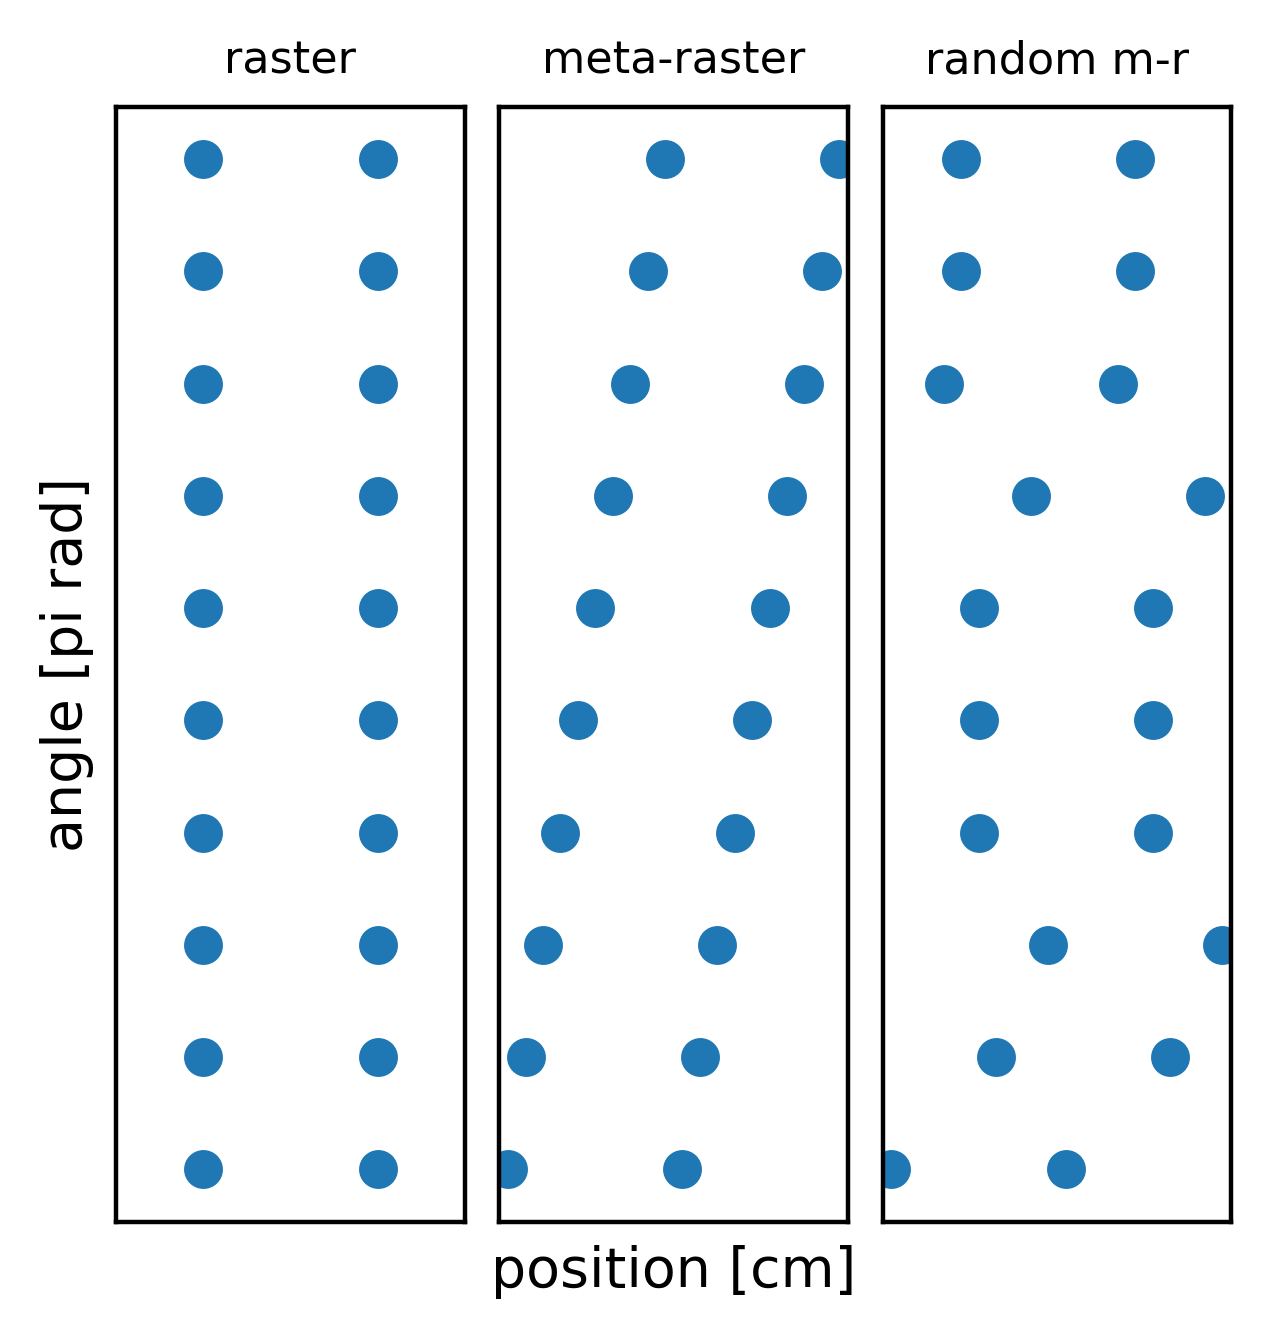

In [60]:
fig = plt.figure(figsize=(8.85/2.54, 8.85/2.54), dpi=400)
# plt.figure()

plt.subplot(1,3,1)
[x for x in raster_scan(10, 2, width_fraction=0.1, nmeta=1, random=True, plot=True)]
plt.title('raster', fontsize=8)
plt.xticks([])
plt.yticks([])
plt.xlim([0, 1])
plt.xlabel('')

plt.subplot(1,3,2)
[x for x in raster_scan(10, 2, width_fraction=0.1, nmeta=0, random=False, plot=True)]
plt.title('meta-raster', fontsize=8)
plt.xticks([])
plt.yticks([])
plt.xlim([0, 1])
plt.ylabel('')

plt.subplot(1,3,3)
[x for x in raster_scan(10, 2, width_fraction=0.1, nmeta=0, random=True, plot=True)]
plt.title('random m-r', fontsize=8)
plt.xticks([])
plt.yticks([])
plt.xlim([0, 1])
plt.ylabel('')
plt.xlabel('')

# plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0, left=0.1, right=0.9, bottom=0.1, top=0.9)

plt.savefig('./figures/gap/compare_procedure.png', format='png',
        transparent=False, bbox_inches=None, pad_inches=0,
        frameon=False)

plt.show()

# Compare the measurement anisotropy of each method

Focus in on a small corner of the second quadrant.

In [5]:
ROI = [[7/16, .5], [7/16, .5]] # The region of interest for the coverage map
probe_width = 1/256

num_angles = [11,101,499] # the number of projection angles

# num_angles = list({int(10**x) for x in np.arange(0, 3.1, 0.1)}) # the number of projection angles
pixel_fractions = [1.] # the pixel size compared to the beam width
gap_fractions = [1./8] # the fraction of space covered by the beam

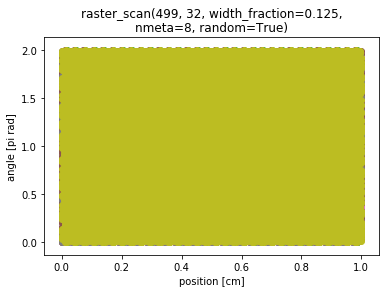

In [84]:
# default scan
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'raster', anisotropy=True)
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'meta', nmeta=0, anisotropy=True)
generate_maps(ROI, probe_width, num_angles, pixel_fractions, gap_fractions,
              'random', nmeta=0, random=True, anisotropy=True)
plt.show()

[11, 101, 499]


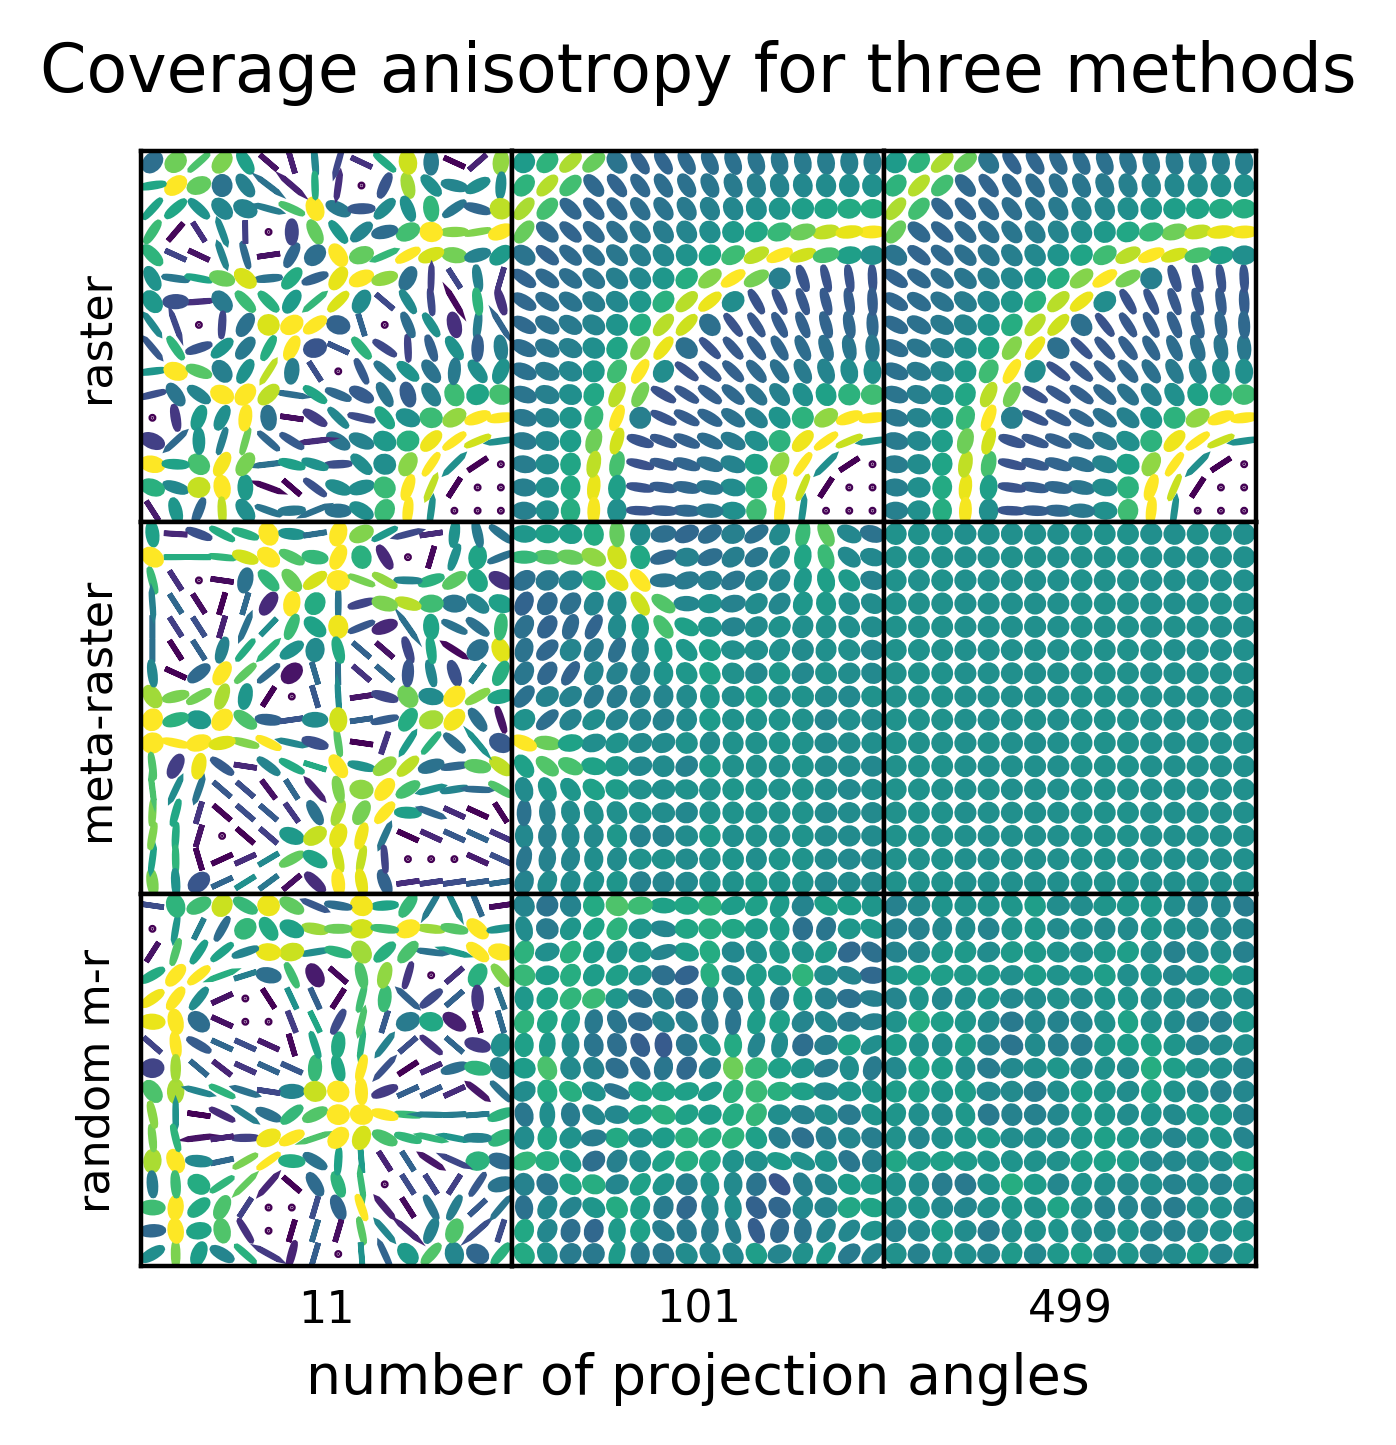

In [13]:

# num_angles = list({int(10**x) for x in np.arange(0, 3.1, 0.1)}) # the number of projection angles
print(sorted(num_angles))
# num_angles = [6,15,39,100]
# num_angles = [10, 100, 501]
# num_angles = [10,31,100]


fig = plt.figure(figsize=(8.85/2.54, 8.85/2.54), dpi=400)
# fig = plt.figure()
folders = ['raster','meta','random']
# folders = ['raster coverage','meta-raster coverage','random meta-raster coverage']
short_names = ['raster', 'meta-raster', 'random m-r']
cols = sorted(num_angles)
rows = folders

for i in range(len(rows)):
    for j in range(len(cols)):

        # scale the results as fraction of the most covered pixel
        themap = np.load('./data/gap/{}/a{}_{}_{}.npy'.format(rows[i], cols[j], 1., 1./8))
#         themap /= np.max(themap)
#             print(np.max(themap), np.min(themap))
#         fig = plt.figure(figsize=(8.85/2.54, 8.85/2.54), dpi=400)
        axis = plt.subplot(len(rows), len(cols), i*len(cols) + j + 1)
        plot_coverage_anisotropy(themap, color='coverage', glyph_density=1, trace_normal=cols[j]/4)
        plt.gca().get_yaxis().set_ticks([])
        plt.gca().get_xaxis().set_ticks([])

        if j == 0:
            plt.ylabel(str(short_names[i]), fontsize=8)
        if i == len(rows) - 1:
            plt.xlabel(str(cols[j]), fontsize=8)
        plt.suptitle('Coverage anisotropy for three methods')

fig.text(0.5, 0.0, 'number of projection angles', ha='center', va='bottom')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0.1, right=0.9, bottom=0.1, top=0.9)
plt.savefig('./figures/gap/raster_anisotropy.png', format='png',
        transparent=False, bbox_inches=None, pad_inches=0,
        frameon=False)
#     return fig
plt.show()

(64, 64, 2, 2)